In [1]:
%load_ext tensorboard
import datetime
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import numpy as np
import dataset


In [2]:
import importlib
import hebrew
importlib.reload(hebrew)
importlib.reload(dataset)
MAXLEN = 30
BATCH_SIZE = 16  # 512
data = dataset.load_file(BATCH_SIZE, 0.1, maxlen=MAXLEN,
                         filenames=['texts/short_table.txt', 'texts/treasure_island.txt'])  # 'texts/bible.txt',


In [3]:
l2 = tf.keras.regularizers.l2

EMBED_DIM = 2**10  # larger -> quicker opening. knee at 1024

inp = tf.keras.Input(shape=(data.input_texts.shape[1],), batch_size=BATCH_SIZE)

h = layers.Embedding(len(data.letters_table), EMBED_DIM, mask_zero=True)(inp)
# h = layers.Dropout(DROP)(h)

h = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(h)  # =l2(1e-6)
h = layers.Dropout(0.4)(h) 

h = layers.Bidirectional(layers.GRU(256, return_sequences=True, recurrent_regularizer=None), merge_mode='sum')(h)
h = layers.Dropout(0.4)(h) 

# h = h1  # layers.Add()([h1, h])
    
h = layers.Dense(256, activation='relu', kernel_regularizer=l2(5e-5))(h)
h = layers.Dropout(0.4)(h) 
#h = layers.Add()([h1, h])
# for k in range(1):
#     h = layers.Add()([h, Dense(256)(h)])

h = layers.Dense(data.niqqud_texts.shape[2])(h)
model_niqqud = tf.keras.Model(inputs=[inp], outputs=[h])
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_niqqud.compile(loss='mean_squared_logarithmic_error', optimizer=adam, metrics=['accuracy'])

plot_model(model_niqqud, to_file='model.png')
model_niqqud.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 30)]                0         
_________________________________________________________________
embedding (Embedding)        (16, 30, 1024)            70656     
_________________________________________________________________
bidirectional (Bidirectional (16, 30, 256)             1969152   
_________________________________________________________________
dropout (Dropout)            (16, 30, 256)             0         
_________________________________________________________________
bidirectional_1 (Bidirection (16, 30, 256)             789504    
_________________________________________________________________
dropout_1 (Dropout)          (16, 30, 256)             0         
_________________________________________________________________
dense (Dense)                (16, 30, 256)             65792 

In [4]:

log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
def fit(EPOCHS):
    return model_niqqud.fit(data.input_texts, data.niqqud_texts,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(data.input_validation, data.niqqud_validation),
          callbacks=[
              # tf.keras.callbacks.ModelCheckpoint(filepath='niqqud_checkpoints/ckpt_{epoch}', save_weights_only=True),
              tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2, verbose=1),
              tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=0, min_lr=0.0001),
              # tensorboard_callback,
          ]
    )

history = fit(EPOCHS=5)

Train on 33436 samples, validate on 3716 samples
Epoch 1/5
33436/33436 [==============================] - 70s 2ms/sample - loss: 0.0029 - accuracy: 0.8151 - val_loss: 0.0017 - val_accuracy: 0.8886
Epoch 2/5
33436/33436 [==============================] - 54s 2ms/sample - loss: 0.0016 - accuracy: 0.8974 - val_loss: 0.0013 - val_accuracy: 0.9186
Epoch 3/5
33436/33436 [==============================] - 56s 2ms/sample - loss: 0.0014 - accuracy: 0.9171 - val_loss: 0.0012 - val_accuracy: 0.9285
Epoch 4/5
33436/33436 [==============================] - 57s 2ms/sample - loss: 0.0013 - accuracy: 0.9254 - val_loss: 0.0011 - val_accuracy: 0.9319
Epoch 5/5
33436/33436 [==============================] - 59s 2ms/sample - loss: 0.0012 - accuracy: 0.9299 - val_loss: 0.0011 - val_accuracy: 0.9354


In [ ]:
history1 = fit(EPOCHS=10)

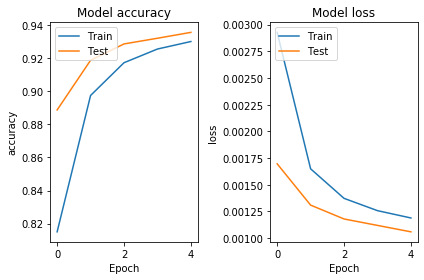

In [6]:
import matplotlib.pyplot as plt

for n, v in enumerate(['accuracy', 'loss'], 1):
    plt.subplot(1, 2, n)
    plt.plot(history.history[v][0:])
    plt.plot(history.history['val_' +  v][0:])
    plt.title('Model ' + v)
    plt.ylabel(v)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    
plt.tight_layout()

In [7]:

model = tf.keras.Model(inputs=[inp], outputs=[tf.keras.layers.Softmax()(h)])

def print_predictions(k):
    s = slice(k*BATCH_SIZE, (k+1)*BATCH_SIZE)
    batch = data.input_validation[s]
    actual = model.predict(batch)
    expected = data.niqqud_validation[s]
    for r in zip(data.merge(batch, ns=actual), data.merge(batch, ns=expected)):
        print(r)

print_predictions(35)

0
0
('טִבְעוֹ שֶל עוֹלָם הַשוֹאֵל הַשוֹכֵר בְהֵמָה', 'טִבְעוֹ שֶל עוֹלָם הַשוֹאֵל הַשוֹכֵר בְהֵמָה')
('שְעָרוֹת גְדָלוֹת אְפִלוּ הִנִיחָה כַלָה', 'שְעָרוֹת גְדֵלוֹת אֲפִלוּ הֵנִיחָה כֻלָה')
('וְאוֹמֵר אַשְרֵי אָנוּש יַעֹשֶה זֹאת וּבֵן', 'וְאוֹמֵר אַשְרֵי אֱנוֹש יַעֲשֶה זֹאת וּבֶן')
('שֶאֵינוֹ נָקוּב וְכֵן צְרִיכִין לְדַקְדֵק', 'שֶאֵינוֹ נָקוּב וְכֵן צְרִיכִין לְדַקְדֵק')
('מִשְחַק-יַלָדִים לִמְצֹא אֶת הַסְחוֹרָה;', 'מִשְחַק-יְלָדִים לִמְצֹא אֶת הַסְחוֹרָה;')
('אַחַת כְדֵי שֶיִשְמוֹר שַבָתוֹת הַרְבֶה', 'אַחַת כְדֵי שֶיִשְמוֹר שַבָתוֹת הַרְבֵה')
('שֶכֵן מִתוֹךְ תְרִיסַר מִלִים הָבִינוֹתִי,', 'שֶכֵן מִתוֹךְ תְרֵיסַר מִלִים הֲבִינוֹתִי,')
('בְיַד רַק מַנִיחִין אוֹתוֹ עַל הַשַלְחָן', 'בַיָד רַק מַנִיחִין אוֹתוֹ עַל הַשֻלְחָן')
('טוֹב לְפָדוֹת אֶת הַכַפֵרוֹת בְמָמוֹן', 'טוֹב לִפְדוֹת אֶת הַכַפָרוֹת בְמָמוֹן')
('שֶנֶחְלְקוּ לַחְבוֹרוֹת הַרְבֶה אֵפִלוּ', 'שֶנֶחְלְקוּ לַחֲבוּרוֹת הַרְבֵה אֲפִלוּ')
('הָלְכָה הַמַחְשָבָה עַל הַמַטְמוֹן וּכְבָשֶה', 'הָלְכָה הַמַחֲשָבָה עַל הַמַטְמוֹן וְכָבְשָה')
(

In [ ]:
# model.load_weights(tf.train.latest_checkpoint('niqqud_checkpoints/'))

In [ ]:
print(history.history['val_accuracy'])

In [ ]:
%tensorboard --logdir logs\fit